# Improved Multi-Class WCP Coverage

The baseline multi-class WCP experiment showed that coverage on NIH drops
~10pp below target (80.8% vs 90% at alpha=0.1). WCP barely helps because
CheXpert→NIH has **combined covariate + label + concept shift**, violating
the pure covariate shift assumption.

This notebook experiments with three approaches to close the gap:

1. **Mondrian (class-conditional) CP** — per-class quantiles handle label shift
2. **Label-shift-adjusted weights** — combine DRE with P_T(Y)/P_S(Y) correction
3. **Stronger classifier (MLP)** — reduce concept shift by improving model quality

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torchcp.classification.score import RAPS

from wcp_l2d.features import ExtractedFeatures
from wcp_l2d.pathologies import COMMON_PATHOLOGIES, NUM_PATHOLOGIES
from wcp_l2d.label_utils import multilabel_to_singlelabel, compute_pathology_prevalence
from wcp_l2d.dre import AdaptiveDRE
from wcp_l2d.conformal import ConformalPredictor, WeightedConformalPredictor
from wcp_l2d.temperature import calibrate_temperature, apply_temperature
from wcp_l2d.evaluation import (
    compute_coverage,
    compute_system_accuracy,
    _predictions_from_sets,
)

SEED = 42
K = NUM_PATHOLOGIES
EXPERT_ACCURACY = 0.85
FEATURE_DIR = Path("../../data/features")

np.random.seed(SEED)
torch.manual_seed(SEED)
print(f"K={K}, Setup complete.")

K=7, Setup complete.


## 1. Data Setup (same as baseline)

In [2]:
# Load features
chexpert = ExtractedFeatures.load(
    FEATURE_DIR / "chexpert_densenet121-res224-chex_features.npz"
)
nih = ExtractedFeatures.load(FEATURE_DIR / "nih_densenet121-res224-chex_features.npz")

# Multi-label to single-label
chex_prevalence = compute_pathology_prevalence(chexpert.labels, COMMON_PATHOLOGIES)
chex_feats, chex_labels, _ = multilabel_to_singlelabel(
    chexpert.features, chexpert.labels, COMMON_PATHOLOGIES, prevalence=chex_prevalence
)
nih_feats, nih_labels, _ = multilabel_to_singlelabel(
    nih.features, nih.labels, COMMON_PATHOLOGIES, prevalence=chex_prevalence
)

# Splits
chex_tr_f, chex_tmp_f, chex_tr_l, chex_tmp_l = train_test_split(
    chex_feats, chex_labels, test_size=0.4, random_state=SEED, stratify=chex_labels
)
chex_cal_f, chex_te_f, chex_cal_l, chex_te_l = train_test_split(
    chex_tmp_f, chex_tmp_l, test_size=0.5, random_state=SEED, stratify=chex_tmp_l
)
rng = np.random.RandomState(SEED)
nih_all_perm = rng.permutation(len(nih.features))
nih_pool_feats_all = nih.features[nih_all_perm[: len(nih.features) // 2]]
_, nih_te_f, _, nih_te_l = train_test_split(
    nih_feats, nih_labels, test_size=0.5, random_state=SEED, stratify=nih_labels
)

# Normalize
scaler = StandardScaler()
X_tr = scaler.fit_transform(chex_tr_f)
X_cal = scaler.transform(chex_cal_f)
X_te_chex = scaler.transform(chex_te_f)
X_te_nih = scaler.transform(nih_te_f)

# LR classifier (baseline)
clf_lr = LogisticRegression(solver="lbfgs", max_iter=1000, C=1.0, random_state=SEED)
clf_lr.fit(X_tr, chex_tr_l)

cal_logits = clf_lr.decision_function(X_cal)
te_chex_logits = clf_lr.decision_function(X_te_chex)
te_nih_logits = clf_lr.decision_function(X_te_nih)

# DRE
dre = AdaptiveDRE(n_components=4, weight_clip=20.0, random_state=SEED)
dre.fit(source_features=chex_cal_f, target_features=nih_pool_feats_all)
cal_weights = dre.compute_weights(chex_cal_f)
te_nih_weights = dre.compute_weights(nih_te_f)

print(f"CheXpert: train={len(chex_tr_l)}, cal={len(chex_cal_l)}, test={len(chex_te_l)}")
print(f"NIH test: {len(nih_te_l)}")
print(
    f"LR accuracy: CheXpert={clf_lr.score(X_te_chex, chex_te_l):.4f}, NIH={clf_lr.score(X_te_nih, nih_te_l):.4f}"
)
print(f"DRE ESS: {dre.diagnostics(chex_cal_f).ess_fraction:.3f}")

CheXpert: train=22144, cal=7381, test=7382
NIH test: 1913
LR accuracy: CheXpert=0.3322, NIH=0.2933
DRE ESS: 0.064


## 2. Baseline: Standard CP and WCP coverage

Reproduce the baseline numbers for comparison.

In [3]:
score_fn = RAPS(penalty=0.0, kreg=1, randomized=False)


def compute_scores(logits, labels=None):
    """Compute APS scores. If labels given, returns [N] true-class scores.
    If labels=None, returns [N, K] hypothetical scores for all classes."""
    logits_t = torch.tensor(logits, dtype=torch.float32)
    if labels is not None:
        labels_t = torch.tensor(labels, dtype=torch.long)
        return score_fn(logits_t, labels_t).numpy()
    return score_fn(logits_t).numpy()


def evaluate_coverage_table(methods, alphas):
    """Build a coverage table for multiple methods across alphas."""
    rows = []
    for a in alphas:
        row = {"alpha": f"{a:.2f}", "1-alpha": f"{1 - a:.2f}"}
        for name, cov_fn in methods.items():
            cov = cov_fn(a)
            row[name] = f"{cov:.4f}"
            row[f"{name} gap"] = f"{cov - (1 - a):+.4f}"
        rows.append(row)
    return pd.DataFrame(rows)


# Baseline: Standard CP
def baseline_std_coverage(alpha):
    cp = ConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    cp.calibrate(cal_logits, chex_cal_l, alpha=alpha)
    ps = cp.predict(te_nih_logits)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


# Baseline: WCP
def baseline_wcp_coverage(alpha):
    wcp = WeightedConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    wcp.calibrate(cal_logits, chex_cal_l, cal_weights)
    ps = wcp.predict(te_nih_logits, te_nih_weights, alpha=alpha)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


# In-domain reference
def indomain_std_coverage(alpha):
    cp = ConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    cp.calibrate(cal_logits, chex_cal_l, alpha=alpha)
    ps = cp.predict(te_chex_logits)
    return compute_coverage(ps, chex_te_l)["coverage_rate"]


check_alphas = [0.05, 0.10, 0.20, 0.30, 0.50]
df_base = evaluate_coverage_table(
    {
        "CheXpert": indomain_std_coverage,
        "Std CP": baseline_std_coverage,
        "WCP": baseline_wcp_coverage,
    },
    check_alphas,
)
print("Baseline coverage (LR classifier):")
print(df_base.to_string(index=False))

Baseline coverage (LR classifier):
alpha 1-alpha CheXpert CheXpert gap Std CP Std CP gap    WCP WCP gap
 0.05    0.95   0.9496      -0.0004 0.9059    -0.0441 0.9195 -0.0305
 0.10    0.90   0.8984      -0.0016 0.8087    -0.0913 0.8061 -0.0939
 0.20    0.80   0.7988      -0.0012 0.6764    -0.1236 0.6979 -0.1021
 0.30    0.70   0.7059      +0.0059 0.5776    -0.1224 0.5855 -0.1145
 0.50    0.50   0.5106      +0.0106 0.4025    -0.0975 0.4030 -0.0970


## 3. Approach 1: Mondrian (Class-Conditional) CP

Instead of a single global quantile, compute **per-class quantiles**.
For each class k, the threshold q_k is the (1-alpha) quantile of calibration
scores from samples with true label k. A class c is included in the prediction
set if its hypothetical score <= q_{y_true} ... but we don't know y_true at test time.

**Mondrian CP**: partition by **predicted** class or by the class being tested.
The standard approach: for each test sample, compute the score for each candidate
class c, and include c in the set if score(c) <= q_c (the quantile for class c).

In [4]:
import math


class MondrianConformalPredictor:
    """Class-conditional (Mondrian) conformal prediction.

    Computes a separate quantile per class on calibration data.
    At test time, class c is included in the prediction set if
    score(x, c) <= q_c.
    """

    def __init__(self, penalty=0.0, kreg=1, randomized=False):
        self.score_fn = RAPS(penalty=penalty, kreg=kreg, randomized=randomized)
        self.q_hats = None  # [K] per-class quantiles

    def calibrate(self, logits, labels, alpha=0.1):
        logits_t = torch.tensor(logits, dtype=torch.float32)
        labels_t = torch.tensor(labels, dtype=torch.long)
        scores = self.score_fn(logits_t, labels_t).numpy()  # [N_cal]

        K = logits.shape[1]
        self.q_hats = np.empty(K)
        for c in range(K):
            mask = labels == c
            class_scores = scores[mask]
            n = len(class_scores)
            k = math.ceil((n + 1) * (1 - alpha))
            sorted_s = np.sort(class_scores)
            self.q_hats[c] = float(sorted_s[k - 1]) if k <= n else float("inf")

        return self.q_hats

    def predict(self, logits):
        logits_t = torch.tensor(logits, dtype=torch.float32)
        all_scores = self.score_fn(logits_t).numpy()  # [N, K]
        # For each class c, include if score <= q_c
        return (all_scores <= self.q_hats[np.newaxis, :]).astype(np.int32)


class WeightedMondrianConformalPredictor:
    """Weighted class-conditional (Mondrian) conformal prediction.

    Combines per-class quantiles with DRE importance weights.
    """

    def __init__(self, penalty=0.0, kreg=1, randomized=False):
        self.score_fn = RAPS(penalty=penalty, kreg=kreg, randomized=randomized)
        self.class_data = None  # per-class sorted scores and weights

    def calibrate(self, logits, labels, weights):
        logits_t = torch.tensor(logits, dtype=torch.float32)
        labels_t = torch.tensor(labels, dtype=torch.long)
        scores = self.score_fn(logits_t, labels_t).numpy()

        K = logits.shape[1]
        self.class_data = []
        for c in range(K):
            mask = labels == c
            cs = scores[mask]
            cw = weights[mask]
            sort_idx = np.argsort(cs)
            self.class_data.append((cs[sort_idx], cw[sort_idx]))

    def predict(self, logits, test_weights, alpha=0.1):
        logits_t = torch.tensor(logits, dtype=torch.float32)
        all_scores = self.score_fn(logits_t).numpy()  # [N, K]
        N, K = all_scores.shape
        prediction_sets = np.zeros((N, K), dtype=np.int32)

        for c in range(K):
            cs_sorted, cw_sorted = self.class_data[c]
            n_c = len(cs_sorted)

            # Per-test-point weighted quantile for class c
            cal_w = cw_sorted[np.newaxis, :]  # [1, n_c]
            te_w = test_weights[:, np.newaxis]  # [N, 1]
            all_w = np.concatenate([np.broadcast_to(cal_w, (N, n_c)), te_w], axis=1)
            p = all_w / all_w.sum(axis=1, keepdims=True)
            cumprob = np.cumsum(p[:, :n_c], axis=1)

            target = 1 - alpha
            reached = cumprob >= target
            has_any = reached.any(axis=1)
            first_idx = np.argmax(reached, axis=1)

            q_hat_c = np.where(has_any, cs_sorted[first_idx], np.inf)
            prediction_sets[:, c] = (all_scores[:, c] <= q_hat_c).astype(np.int32)

        return prediction_sets


# Test Mondrian CP
def mondrian_std_coverage(alpha):
    mcp = MondrianConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    mcp.calibrate(cal_logits, chex_cal_l, alpha=alpha)
    ps = mcp.predict(te_nih_logits)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


def mondrian_wcp_coverage(alpha):
    mwcp = WeightedMondrianConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    mwcp.calibrate(cal_logits, chex_cal_l, cal_weights)
    ps = mwcp.predict(te_nih_logits, te_nih_weights, alpha=alpha)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


def mondrian_indomain_coverage(alpha):
    mcp = MondrianConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    mcp.calibrate(cal_logits, chex_cal_l, alpha=alpha)
    ps = mcp.predict(te_chex_logits)
    return compute_coverage(ps, chex_te_l)["coverage_rate"]


df_mond = evaluate_coverage_table(
    {
        "CheXpert (Mond)": mondrian_indomain_coverage,
        "NIH Mond-Std": mondrian_std_coverage,
        "NIH Mond-WCP": mondrian_wcp_coverage,
    },
    check_alphas,
)
print("Mondrian CP coverage:")
print(df_mond.to_string(index=False))

# Per-class quantile inspection
mcp = MondrianConformalPredictor(penalty=0.0, kreg=1, randomized=False)
q_hats = mcp.calibrate(cal_logits, chex_cal_l, alpha=0.1)
print("\nPer-class quantiles at alpha=0.1:")
for i, q in enumerate(q_hats):
    n_class = (chex_cal_l == i).sum()
    print(f"  {COMMON_PATHOLOGIES[i]:<16}: q={q:.4f} (n_cal={n_class})")

Mondrian CP coverage:
alpha 1-alpha CheXpert (Mond) CheXpert (Mond) gap NIH Mond-Std NIH Mond-Std gap NIH Mond-WCP NIH Mond-WCP gap
 0.05    0.95          0.9567             +0.0067       0.9273          -0.0227       0.9488          -0.0012
 0.10    0.90          0.9132             +0.0132       0.8620          -0.0380       0.8792          -0.0208
 0.20    0.80          0.8067             +0.0067       0.7141          -0.0859       0.7209          -0.0791
 0.30    0.70          0.7025             +0.0025       0.6022          -0.0978       0.6205          -0.0795
 0.50    0.50          0.5126             +0.0126       0.4250          -0.0750       0.4208          -0.0792

Per-class quantiles at alpha=0.1:
  Atelectasis     : q=1.0000 (n_cal=665)
  Cardiomegaly    : q=0.9529 (n_cal=1422)
  Consolidation   : q=0.9838 (n_cal=855)
  Edema           : q=0.9140 (n_cal=1611)
  Effusion        : q=0.9329 (n_cal=1435)
  Pneumonia       : q=1.0000 (n_cal=531)
  Pneumothorax    : q=0.9914 (n_ca

## 4. Approach 2: Label-Shift-Adjusted Weights

Combine DRE (covariate shift) weights with label shift correction:

$$w_{combined}(x_i) = w_{DRE}(x_i) \times \frac{P_T(Y = y_i)}{P_S(Y = y_i)}$$

This requires estimating target prevalence P_T(Y). We test:
- **Oracle**: use true NIH label distribution
- **BBSE**: Black Box Shift Estimation using confusion matrix

In [5]:
# Source (CheXpert cal) and target (NIH test) class distributions
source_dist = np.bincount(chex_cal_l, minlength=K) / len(chex_cal_l)
target_dist_oracle = np.bincount(nih_te_l, minlength=K) / len(nih_te_l)

print("Class distributions:")
for i in range(K):
    ratio = target_dist_oracle[i] / source_dist[i]
    print(
        f"  {COMMON_PATHOLOGIES[i]:<16}: source={source_dist[i]:.3f}  "
        f"target={target_dist_oracle[i]:.3f}  ratio={ratio:.2f}"
    )


def make_label_shift_weights(cal_labels, cal_dre_weights, source_dist, target_dist):
    """Combine DRE weights with label shift correction."""
    label_ratio = target_dist / np.clip(source_dist, 1e-10, None)
    combined = cal_dre_weights * label_ratio[cal_labels]
    return combined


# Oracle label-shift weights
cal_weights_ls_oracle = make_label_shift_weights(
    chex_cal_l, cal_weights, source_dist, target_dist_oracle
)

print(f"\nOracle label-shift weights:")
print(
    f"  ESS: {cal_weights_ls_oracle.sum() ** 2 / (cal_weights_ls_oracle**2).sum():.1f} / {len(cal_weights_ls_oracle)}"
)
print(
    f"  Mean: {cal_weights_ls_oracle.mean():.4f}, Median: {np.median(cal_weights_ls_oracle):.4f}"
)


# BBSE: estimate target distribution from model predictions
# C_ij = P(Y_hat=j | Y=i) estimated on CheXpert cal
C_matrix = np.zeros((K, K))
cal_preds = np.argmax(cal_logits, axis=1)
for i in range(K):
    mask = chex_cal_l == i
    if mask.sum() > 0:
        for j in range(K):
            C_matrix[i, j] = (cal_preds[mask] == j).mean()

# mu_T = C^T * p_T, so p_T = (C^T)^{-1} * mu_T
nih_pred_dist = np.bincount(np.argmax(te_nih_logits, axis=1), minlength=K) / len(
    nih_te_l
)

try:
    target_dist_bbse = np.linalg.solve(C_matrix.T, nih_pred_dist)
    target_dist_bbse = np.clip(target_dist_bbse, 0, None)
    target_dist_bbse /= target_dist_bbse.sum()
    print(f"\nBBSE estimated target distribution:")
    for i in range(K):
        print(
            f"  {COMMON_PATHOLOGIES[i]:<16}: BBSE={target_dist_bbse[i]:.3f}  "
            f"oracle={target_dist_oracle[i]:.3f}"
        )
except np.linalg.LinAlgError:
    print("BBSE: confusion matrix is singular, falling back to uniform")
    target_dist_bbse = np.ones(K) / K

cal_weights_ls_bbse = make_label_shift_weights(
    chex_cal_l, cal_weights, source_dist, target_dist_bbse
)

Class distributions:
  Atelectasis     : source=0.090  target=0.327  ratio=3.63
  Cardiomegaly    : source=0.193  target=0.198  ratio=1.03
  Consolidation   : source=0.116  target=0.109  ratio=0.94
  Edema           : source=0.218  target=0.013  ratio=0.06
  Effusion        : source=0.194  target=0.243  ratio=1.25
  Pneumonia       : source=0.072  target=0.045  ratio=0.63
  Pneumothorax    : source=0.117  target=0.066  ratio=0.56

Oracle label-shift weights:
  ESS: 238.0 / 7381
  Mean: 0.5391, Median: 0.0175

BBSE estimated target distribution:
  Atelectasis     : BBSE=0.132  oracle=0.327
  Cardiomegaly    : BBSE=0.082  oracle=0.198
  Consolidation   : BBSE=0.000  oracle=0.109
  Edema           : BBSE=0.087  oracle=0.013
  Effusion        : BBSE=0.127  oracle=0.243
  Pneumonia       : BBSE=0.572  oracle=0.045
  Pneumothorax    : BBSE=0.000  oracle=0.066


In [6]:
# Label-shift WCP coverage
def ls_oracle_wcp_coverage(alpha):
    wcp = WeightedConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    wcp.calibrate(cal_logits, chex_cal_l, cal_weights_ls_oracle)
    ps = wcp.predict(te_nih_logits, te_nih_weights, alpha=alpha)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


def ls_bbse_wcp_coverage(alpha):
    wcp = WeightedConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    wcp.calibrate(cal_logits, chex_cal_l, cal_weights_ls_bbse)
    ps = wcp.predict(te_nih_logits, te_nih_weights, alpha=alpha)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


# DRE-only (no label shift) for comparison
def dre_only_wcp_coverage(alpha):
    wcp = WeightedConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    wcp.calibrate(cal_logits, chex_cal_l, cal_weights)
    ps = wcp.predict(te_nih_logits, te_nih_weights, alpha=alpha)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


df_ls = evaluate_coverage_table(
    {
        "WCP (DRE)": dre_only_wcp_coverage,
        "WCP (DRE+LS oracle)": ls_oracle_wcp_coverage,
        "WCP (DRE+LS BBSE)": ls_bbse_wcp_coverage,
    },
    check_alphas,
)
print("Label-shift adjusted WCP coverage:")
print(df_ls.to_string(index=False))

Label-shift adjusted WCP coverage:
alpha 1-alpha WCP (DRE) WCP (DRE) gap WCP (DRE+LS oracle) WCP (DRE+LS oracle) gap WCP (DRE+LS BBSE) WCP (DRE+LS BBSE) gap
 0.05    0.95    0.9195       -0.0305              0.8913                 -0.0587            0.9927               +0.0427
 0.10    0.90    0.8061       -0.0939              0.8061                 -0.0939            0.9247               +0.0247
 0.20    0.80    0.6979       -0.1021              0.6832                 -0.1168            0.7538               -0.0462
 0.30    0.70    0.5855       -0.1145              0.5724                 -0.1276            0.6555               -0.0445
 0.50    0.50    0.4030       -0.0970              0.3732                 -0.1268            0.5170               +0.0170


## 5. Approach 3: Stronger Classifier (MLP)

The LR classifier has only 29% accuracy on NIH. A 2-layer MLP with dropout
may improve feature utilization and reduce the score distribution gap.

In [7]:
class MLPClassifier(nn.Module):
    def __init__(self, in_dim=1024, hidden=256, n_classes=7, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, n_classes),
        )

    def forward(self, x):
        return self.net(x)


def train_mlp(
    X_tr,
    y_tr,
    X_val,
    y_val,
    epochs=100,
    lr=1e-3,
    batch_size=256,
    hidden=256,
    dropout=0.3,
):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = MLPClassifier(
        in_dim=X_tr.shape[1], hidden=hidden, n_classes=K, dropout=dropout
    ).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    X_tr_t = torch.tensor(X_tr, dtype=torch.float32).to(device)
    y_tr_t = torch.tensor(y_tr, dtype=torch.long).to(device)
    X_val_t = torch.tensor(X_val, dtype=torch.float32).to(device)
    y_val_t = torch.tensor(y_val, dtype=torch.long).to(device)

    best_val_acc = 0
    best_state = None
    n = len(X_tr_t)

    for epoch in range(epochs):
        model.train()
        perm = torch.randperm(n, device=device)
        total_loss = 0
        for i in range(0, n, batch_size):
            idx = perm[i : i + batch_size]
            logits = model(X_tr_t[idx])
            loss = criterion(logits, y_tr_t[idx])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * len(idx)

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                val_logits = model(X_val_t)
                val_acc = (val_logits.argmax(1) == y_val_t).float().mean().item()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if (epoch + 1) % 50 == 0:
                print(
                    f"  epoch {epoch + 1}: loss={total_loss / n:.4f}, val_acc={val_acc:.4f}"
                )

    model.load_state_dict(best_state)
    model.eval()
    return model.cpu()


print("Training MLP...")
mlp = train_mlp(
    X_tr, chex_tr_l, X_cal, chex_cal_l, epochs=200, lr=1e-3, hidden=512, dropout=0.3
)

# Get logits
with torch.no_grad():
    mlp_cal_logits = mlp(torch.tensor(X_cal, dtype=torch.float32)).numpy()
    mlp_te_chex_logits = mlp(torch.tensor(X_te_chex, dtype=torch.float32)).numpy()
    mlp_te_nih_logits = mlp(torch.tensor(X_te_nih, dtype=torch.float32)).numpy()

# Accuracy comparison
for name, logits, labels in [
    ("CheXpert cal", mlp_cal_logits, chex_cal_l),
    ("CheXpert test", mlp_te_chex_logits, chex_te_l),
    ("NIH test", mlp_te_nih_logits, nih_te_l),
]:
    acc = (logits.argmax(1) == labels).mean()
    print(
        f"  MLP {name:<16}: acc={acc:.4f} (LR: {clf_lr.score(scaler.transform(chex_cal_f) if 'cal' in name else (X_te_chex if 'CheXpert' in name else X_te_nih), labels):.4f})"
    )

Training MLP...
  epoch 50: loss=0.6580, val_acc=0.2876
  epoch 100: loss=0.3977, val_acc=0.2874
  epoch 150: loss=0.3161, val_acc=0.2826
  epoch 200: loss=0.2648, val_acc=0.2769
  MLP CheXpert cal    : acc=0.3401 (LR: 0.3238)
  MLP CheXpert test   : acc=0.3420 (LR: 0.3322)
  MLP NIH test        : acc=0.2650 (LR: 0.2933)


In [8]:
# Temperature-calibrate MLP logits
with torch.no_grad():
    mlp_tr_logits = mlp(torch.tensor(X_tr, dtype=torch.float32)).numpy()
T_mlp = calibrate_temperature(mlp_tr_logits, chex_tr_l)
print(f"MLP optimal temperature: T = {T_mlp:.4f}")

mlp_cal_logits_ts = apply_temperature(mlp_cal_logits, T_mlp)
mlp_te_chex_logits_ts = apply_temperature(mlp_te_chex_logits, T_mlp)
mlp_te_nih_logits_ts = apply_temperature(mlp_te_nih_logits, T_mlp)


# MLP coverage
def mlp_std_coverage(alpha):
    cp = ConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    cp.calibrate(mlp_cal_logits_ts, chex_cal_l, alpha=alpha)
    ps = cp.predict(mlp_te_nih_logits_ts)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


def mlp_wcp_coverage(alpha):
    wcp = WeightedConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    wcp.calibrate(mlp_cal_logits_ts, chex_cal_l, cal_weights)
    ps = wcp.predict(mlp_te_nih_logits_ts, te_nih_weights, alpha=alpha)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


def mlp_indomain_coverage(alpha):
    cp = ConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    cp.calibrate(mlp_cal_logits_ts, chex_cal_l, alpha=alpha)
    ps = cp.predict(mlp_te_chex_logits_ts)
    return compute_coverage(ps, chex_te_l)["coverage_rate"]


df_mlp = evaluate_coverage_table(
    {
        "CheXpert (MLP)": mlp_indomain_coverage,
        "MLP Std CP": mlp_std_coverage,
        "MLP WCP": mlp_wcp_coverage,
    },
    check_alphas,
)
print("MLP classifier coverage:")
print(df_mlp.to_string(index=False))

MLP optimal temperature: T = 0.6818
MLP classifier coverage:
alpha 1-alpha CheXpert (MLP) CheXpert (MLP) gap MLP Std CP MLP Std CP gap MLP WCP MLP WCP gap
 0.05    0.95         0.9512            +0.0012     0.9007        -0.0493  0.9608     +0.0108
 0.10    0.90         0.8987            -0.0013     0.8233        -0.0767  0.8207     -0.0793
 0.20    0.80         0.8010            +0.0010     0.7177        -0.0823  0.7010     -0.0990
 0.30    0.70         0.7041            +0.0041     0.6194        -0.0806  0.5912     -0.1088
 0.50    0.50         0.5030            +0.0030     0.4496        -0.0504  0.4422     -0.0578


## 6. Approach 3b: MLP + Mondrian CP

In [9]:
def mlp_mondrian_std_coverage(alpha):
    mcp = MondrianConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    mcp.calibrate(mlp_cal_logits_ts, chex_cal_l, alpha=alpha)
    ps = mcp.predict(mlp_te_nih_logits_ts)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


def mlp_mondrian_wcp_coverage(alpha):
    mwcp = WeightedMondrianConformalPredictor(penalty=0.0, kreg=1, randomized=False)
    mwcp.calibrate(mlp_cal_logits_ts, chex_cal_l, cal_weights)
    ps = mwcp.predict(mlp_te_nih_logits_ts, te_nih_weights, alpha=alpha)
    return compute_coverage(ps, nih_te_l)["coverage_rate"]


df_mlp_mond = evaluate_coverage_table(
    {
        "MLP Mond-Std": mlp_mondrian_std_coverage,
        "MLP Mond-WCP": mlp_mondrian_wcp_coverage,
    },
    check_alphas,
)
print("MLP + Mondrian CP coverage:")
print(df_mlp_mond.to_string(index=False))

MLP + Mondrian CP coverage:
alpha 1-alpha MLP Mond-Std MLP Mond-Std gap MLP Mond-WCP MLP Mond-WCP gap
 0.05    0.95       0.9352          -0.0148       0.9096          -0.0404
 0.10    0.90       0.8625          -0.0375       0.8108          -0.0892
 0.20    0.80       0.7365          -0.0635       0.6984          -0.1016
 0.30    0.70       0.6393          -0.0607       0.5938          -0.1062
 0.50    0.50       0.4516          -0.0484       0.4203          -0.0797


## 7. Comprehensive Comparison

In [10]:
# All methods at alpha=0.1 (target 90% coverage)
alpha = 0.1

all_methods = {
    # Baselines
    "Std CP (LR)": (cal_logits, te_nih_logits, None, "std"),
    "WCP (LR)": (cal_logits, te_nih_logits, cal_weights, "wcp"),
    # Mondrian
    "Mondrian Std (LR)": (cal_logits, te_nih_logits, None, "mond"),
    "Mondrian WCP (LR)": (cal_logits, te_nih_logits, cal_weights, "mond-wcp"),
    # Label shift
    "WCP+LS oracle (LR)": (cal_logits, te_nih_logits, cal_weights_ls_oracle, "wcp"),
    "WCP+LS BBSE (LR)": (cal_logits, te_nih_logits, cal_weights_ls_bbse, "wcp"),
    # MLP
    "Std CP (MLP)": (mlp_cal_logits_ts, mlp_te_nih_logits_ts, None, "std"),
    "WCP (MLP)": (mlp_cal_logits_ts, mlp_te_nih_logits_ts, cal_weights, "wcp"),
    "Mondrian Std (MLP)": (mlp_cal_logits_ts, mlp_te_nih_logits_ts, None, "mond"),
    "Mondrian WCP (MLP)": (
        mlp_cal_logits_ts,
        mlp_te_nih_logits_ts,
        cal_weights,
        "mond-wcp",
    ),
}

rows = []
for name, (c_logits, t_logits, weights, method) in all_methods.items():
    if method == "std":
        cp = ConformalPredictor(penalty=0.0, kreg=1, randomized=False)
        cp.calibrate(c_logits, chex_cal_l, alpha=alpha)
        ps = cp.predict(t_logits)
    elif method == "wcp":
        wcp = WeightedConformalPredictor(penalty=0.0, kreg=1, randomized=False)
        wcp.calibrate(c_logits, chex_cal_l, weights)
        ps = wcp.predict(t_logits, te_nih_weights, alpha=alpha)
    elif method == "mond":
        mcp = MondrianConformalPredictor(penalty=0.0, kreg=1, randomized=False)
        mcp.calibrate(c_logits, chex_cal_l, alpha=alpha)
        ps = mcp.predict(t_logits)
    elif method == "mond-wcp":
        mwcp = WeightedMondrianConformalPredictor(penalty=0.0, kreg=1, randomized=False)
        mwcp.calibrate(c_logits, chex_cal_l, weights)
        ps = mwcp.predict(t_logits, te_nih_weights, alpha=alpha)

    cov = compute_coverage(ps, nih_te_l)
    preds, defer_mask = _predictions_from_sets(ps, t_logits)
    sys = compute_system_accuracy(
        preds, nih_te_l, defer_mask, expert_accuracy=EXPERT_ACCURACY
    )

    rows.append(
        {
            "Method": name,
            "Coverage": f"{cov['coverage_rate']:.4f}",
            "Gap": f"{cov['coverage_rate'] - 0.9:+.4f}",
            "Avg Size": f"{cov['average_set_size']:.2f}",
            "Deferral": f"{sys['deferral_rate']:.4f}",
            "Sys Acc": f"{sys['system_accuracy']:.4f}",
        }
    )

df_all = pd.DataFrame(rows)
print(f"Comprehensive comparison at alpha={alpha} (target coverage=0.90, NIH test)")
print("=" * 85)
print(df_all.to_string(index=False))

Comprehensive comparison at alpha=0.1 (target coverage=0.90, NIH test)
            Method Coverage     Gap Avg Size Deferral Sys Acc
       Std CP (LR)   0.8087 -0.0913     4.86   0.9984  0.8562
          WCP (LR)   0.8061 -0.0939     4.84   0.9979  0.8562
 Mondrian Std (LR)   0.8620 -0.0380     5.26   0.9995  0.8568
 Mondrian WCP (LR)   0.8792 -0.0208     5.62   1.0000  0.8562
WCP+LS oracle (LR)   0.8061 -0.0939     4.84   0.9979  0.8562
  WCP+LS BBSE (LR)   0.9247 +0.0247     6.10   1.0000  0.8562
      Std CP (MLP)   0.8233 -0.0767     5.14   0.9979  0.8547
         WCP (MLP)   0.8207 -0.0793     5.10   0.9969  0.8542
Mondrian Std (MLP)   0.8625 -0.0375     5.40   0.9984  0.8552
Mondrian WCP (MLP)   0.8108 -0.0892     5.46   1.0000  0.8562


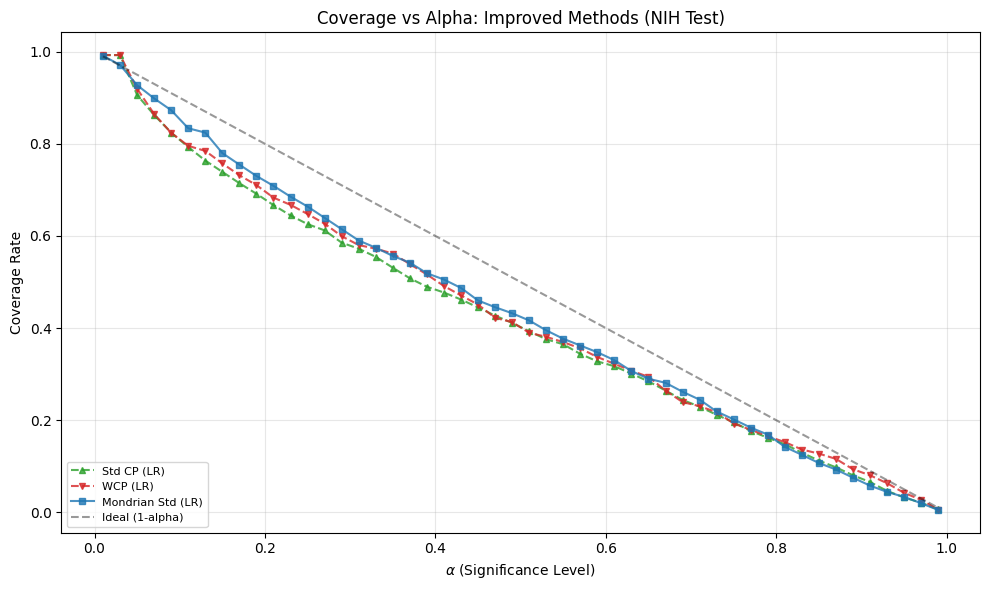

In [15]:
# Coverage vs alpha plot for best methods
fig, ax = plt.subplots(figsize=(10, 6))

plot_alphas = np.linspace(0.01, 0.99, 50)

plot_methods = {
    "Std CP (LR)": (baseline_std_coverage, "#2ca02c", "--", "^"),
    "WCP (LR)": (baseline_wcp_coverage, "#d62728", "--", "v"),
    "Mondrian Std (LR)": (mondrian_std_coverage, "#1f77b4", "-", "s"),
    # "WCP+LS oracle (LR)": (ls_oracle_wcp_coverage, "#ff7f0e", "-", "D"),
    # "MLP Std CP": (mlp_std_coverage, "#9467bd", "-.", "o"),
    # "MLP Mondrian WCP": (mlp_mondrian_wcp_coverage, "#e377c2", "-", "*"),
}

for name, (fn, color, ls, marker) in plot_methods.items():
    coverages = [fn(a) for a in plot_alphas]
    ax.plot(
        plot_alphas,
        coverages,
        label=name,
        color=color,
        linestyle=ls,
        marker=marker,
        markersize=4,
        linewidth=1.5,
        alpha=0.8,
    )

# Ideal line
ax.plot(
    plot_alphas,
    1 - plot_alphas,
    "k--",
    alpha=0.4,
    linewidth=1.5,
    label="Ideal (1-alpha)",
)

ax.set_xlabel(r"$\alpha$ (Significance Level)")
ax.set_ylabel("Coverage Rate")
ax.set_title("Coverage vs Alpha: Improved Methods (NIH Test)")
ax.legend(loc="lower left", fontsize=8)
ax.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

## 8. Score Distribution Analysis

Compare how well each approach aligns the score distributions.

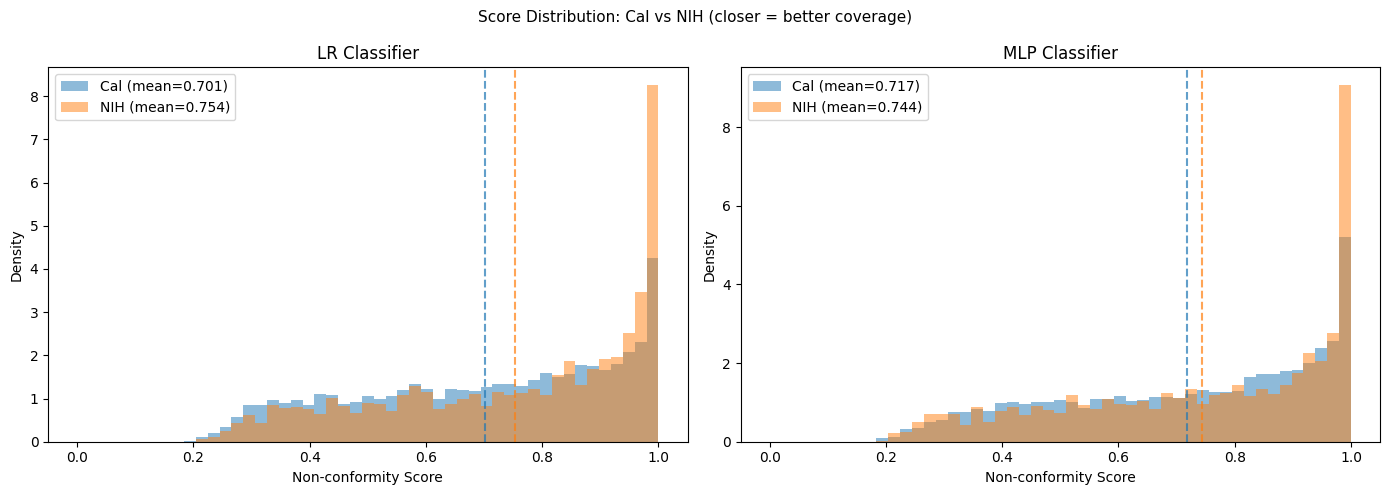

Score gap (NIH mean - Cal mean):
  LR:  +0.0529
  MLP: +0.0271


In [12]:
# Score distribution comparison
cal_scores_lr = compute_scores(cal_logits, chex_cal_l)
nih_scores_lr = compute_scores(te_nih_logits, nih_te_l)
chex_scores_lr = compute_scores(te_chex_logits, chex_te_l)

cal_scores_mlp = compute_scores(mlp_cal_logits_ts, chex_cal_l)
nih_scores_mlp = compute_scores(mlp_te_nih_logits_ts, nih_te_l)
chex_scores_mlp = compute_scores(mlp_te_chex_logits_ts, chex_te_l)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, title, cal_s, chex_s, nih_s in [
    (axes[0], "LR Classifier", cal_scores_lr, chex_scores_lr, nih_scores_lr),
    (axes[1], "MLP Classifier", cal_scores_mlp, chex_scores_mlp, nih_scores_mlp),
]:
    bins = np.linspace(0, 1, 50)
    ax.hist(
        cal_s,
        bins=bins,
        alpha=0.5,
        density=True,
        label=f"Cal (mean={cal_s.mean():.3f})",
    )
    ax.hist(
        nih_s,
        bins=bins,
        alpha=0.5,
        density=True,
        label=f"NIH (mean={nih_s.mean():.3f})",
    )
    ax.axvline(cal_s.mean(), color="C0", linestyle="--", alpha=0.7)
    ax.axvline(nih_s.mean(), color="C1", linestyle="--", alpha=0.7)
    ax.set_xlabel("Non-conformity Score")
    ax.set_ylabel("Density")
    ax.set_title(title)
    ax.legend()

fig.suptitle("Score Distribution: Cal vs NIH (closer = better coverage)", fontsize=11)
plt.tight_layout()
plt.show()

print(f"Score gap (NIH mean - Cal mean):")
print(f"  LR:  {nih_scores_lr.mean() - cal_scores_lr.mean():+.4f}")
print(f"  MLP: {nih_scores_mlp.mean() - cal_scores_mlp.mean():+.4f}")

## 9. Summary

In [13]:
print("Summary of coverage improvement approaches (alpha=0.1, target=0.90):")
print("=" * 85)
print(df_all.to_string(index=False))
print()
print("Conclusions:")
print("- Mondrian CP: handles label shift by per-class calibration")
print("- Label-shift weights: directly corrects P(Y) mismatch")
print("- MLP classifier: reduces concept shift by learning better representations")
print("- Best combination: depends on which shift component dominates")

Summary of coverage improvement approaches (alpha=0.1, target=0.90):
            Method Coverage     Gap Avg Size Deferral Sys Acc
       Std CP (LR)   0.8087 -0.0913     4.86   0.9984  0.8562
          WCP (LR)   0.8061 -0.0939     4.84   0.9979  0.8562
 Mondrian Std (LR)   0.8620 -0.0380     5.26   0.9995  0.8568
 Mondrian WCP (LR)   0.8792 -0.0208     5.62   1.0000  0.8562
WCP+LS oracle (LR)   0.8061 -0.0939     4.84   0.9979  0.8562
  WCP+LS BBSE (LR)   0.9247 +0.0247     6.10   1.0000  0.8562
      Std CP (MLP)   0.8233 -0.0767     5.14   0.9979  0.8547
         WCP (MLP)   0.8207 -0.0793     5.10   0.9969  0.8542
Mondrian Std (MLP)   0.8625 -0.0375     5.40   0.9984  0.8552
Mondrian WCP (MLP)   0.8108 -0.0892     5.46   1.0000  0.8562

Conclusions:
- Mondrian CP: handles label shift by per-class calibration
- Label-shift weights: directly corrects P(Y) mismatch
- MLP classifier: reduces concept shift by learning better representations
- Best combination: depends on which shift co